# Στοιχεία Ομάδας

## Ομάδα Α23
Ξυπόλιτος Γεώργιος, 03113629

Πετρίδης Στέφανος Ευστράτιος, 03113418

# Εισαγωγη dataset και labels/feature extraction

Τα δεδομένα μας περιγράφουν χαρακτηριστικά από εικόνες γραμμάτων όσον αφορά την "γεωμετρία" της ίδιας της εικόνας, όπως το ύψος και το πλάτος, αλλά και στατιστικά χαρακτηριστικά μεταξύ των pixels που απεικονίζει, όπως είναι η διασπορά των τιμών των pixels στον άξονα x. Η ετικέτα κάθε κλάσης είναι το ίδιο το γράμμα που αντιπροσωπεύει.

In [1]:
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
from mlxtend.plotting import plot_confusion_matrix

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_fedf51108e6e474fa4e35bb0b6474bd2(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_d0cfbcdbdc512597f0ccfb3e9fa8e371926ea524','domain': {'id': 'ea2b0617875b45aba36d1e3d7b98e9ee'},
            'password': 'W/Yb2WQY5ycDZ6j_'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

# Your data file was loaded into a StringIO object and you can process the data.
# Please read the documentation of pandas to learn more about your possibilities to load your data.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html
data_1 = get_object_storage_file_with_credentials_fedf51108e6e474fa4e35bb0b6474bd2('Lab1', 'letter-recognition.data')

Αρχικά εισάγουμε τα δεδομένα στο pybook και εξάγουμε τα χαρακτηριστικά και την κλάση κάθε δείγματος.

In [2]:
from sklearn.utils import shuffle

data_df = pd.read_csv(data_1, header=None)

data_df = data_df
labels_df = data_df.iloc[:, 0]
features_df = data_df.iloc[:, 1:]

np_features = features_df.values

Τα δεδομένα μας βρίσκονται σε ένα CSV file, το οποίο παρατηρούμε ότι αποτελείται από δείγματα μετρήσεων σε κάθε γραμμή, στην οποία η πρώτη στήλη αποτελεί την κλάση του δείγματος, ενώ οι υπόλοιπες στήλες αποτελούν τα χαρακτηριστικά του.

In [3]:
print labels_df.iloc[0]
print np_features[0]
print np_features.shape

T
[ 2  8  3  5  1  8 13  0  6  6 10  8  0  8  0  8]
(20000, 16)


Επίσης, παρατηρούμε ότι δεν υπάρχουν missing features σε κανένα από τα samples μας, όπως άλλωστε αναφέρεται και στην περιγραφή των δεδομένων.

Κάνουμε mapping τα γράμματα σε αριθμούς-κλάσεις.

In [4]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J':9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
labels_df = labels_df.replace(mapping)
np_labels = labels_df.values.flatten()

print np_labels
for k in mapping.keys():
    letter = filter(lambda x: x == mapping[k], labels_df)
    print k + ' ' + str(100 * float(len(letter)) / len(labels_df))  + '%'

[19  8  3 ..., 19 18  0]
A 3.945%
C 3.68%
B 3.83%
E 3.84%
D 4.025%
G 3.865%
F 3.875%
I 3.775%
H 3.67%
K 3.695%
J 3.735%
M 3.96%
L 3.805%
O 3.765%
N 3.915%
Q 3.915%
P 4.015%
S 3.74%
R 3.79%
U 4.065%
T 3.98%
W 3.76%
V 3.82%
Y 3.93%
X 3.935%
Z 3.67%


Παρατηρούμε ότι η αναλογία των κλάσεων στο dataset είναι ικανοποιητική, επομένως δεν χρειάζεται κάποιο oversampling ή downsampling.
Αφού ολοκληρωθεί η εξαγωγή των ετικετών και των χαρακτηριστικών από το dataset μας, χωρίζουμε σε train και test set τα δεδομένα μας.

## Διαχωρισμός δεδομένων σε train και test

Διαχωρίζουμε σύμφωνα με την εκφώνηση το dataset μας σε train και test με ποσοστα 70% και 30% αντίστοιχα.

In [5]:
from sklearn.model_selection import train_test_split

train, test, train_labels, test_labels = train_test_split(np_features, np_labels, test_size=0.3, random_state=420)

# Baseline Classification
## Εκπαίδευση και εκτίμηση των dummy classifiers

Σε αυτό το στάδιο δημιουργούμε αρχικά τους dummy classifiers για όλες τις περιπτώσεις.

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

dc_list = []
dc = dict()
dc['uniform'] = DummyClassifier(strategy='uniform')
for k in mapping.values():
    c = 'const' + str(k)
    dc[c] = DummyClassifier(strategy='constant', constant=k)
    dc_list.append((dc[c], c))
dc['freq'] = DummyClassifier(strategy='most_frequent')
dc['strat'] = DummyClassifier(strategy='stratified')

Στη συνέχεια, εκπαιδεύουμε και υπολογίζουμε την ακρίβεια του κάθε dummy classifier που βρίσκεται στη λίστα dc_list.

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

i = 0
f1_m = dict()
f1_w = dict()
accuracy = dict()
confusion = dict()
label_names = mapping.keys()
for d in dc.keys():
    c = dc[d]
    c.fit(train, train_labels)
    pred = c.predict(test)
    t = precision_recall_fscore_support(test_labels, pred, average='weighted')
    print 'F1-Weighted Average for %s:\t%.2f%%' % (d, 100*t[2])
    f1_w[d] = t[2]
    t = precision_recall_fscore_support(test_labels, pred, average='macro')
    print 'F1-Macro Average for\t%s:\t%.2f%%' % (d, 100*t[2])
    f1_m[d] = t[2]
    accuracy[d] = accuracy_score(test_labels, pred)
    confusion[d] = confusion_matrix(test_labels, pred)
    i += 1
    print '\n'

/gpfs/fs01/user/sa2e-9b0c3afc7160f2-4596f700dc87/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Weighted Average for const11:	0.28%
F1-Macro Average for	const11:	0.28%


F1-Weighted Average for const10:	0.26%
F1-Macro Average for	const10:	0.27%


F1-Weighted Average for const13:	0.26%
F1-Macro Average for	const13:	0.27%


F1-Weighted Average for const12:	0.30%
F1-Macro Average for	const12:	0.29%


F1-Weighted Average for const15:	0.37%
F1-Macro Average for	const15:	0.32%


F1-Weighted Average for const14:	0.34%
F1-Macro Average for	const14:	0.31%


F1-Weighted Average for const17:	0.25%
F1-Macro Average for	const17:	0.27%


F1-Weighted Average for const16:	0.24%
F1-Macro Average for	const16:	0.26%


F1-Weighted Average for const19:	0.27%
F1-Macro Average for	const19:	0.28%


F1-Weighted Average for const18:	0.28%
F1-Macro Average for	const18:	0.28%


F1-Weighted Average for strat:	3.59%
F1-Macro Average for	strat:	3.58%


F1-Weighted Average for const5:	0.30%
F1-Macro Average for	const5:	0.29%


F1-Weighted Average for const4:	0.31%
F1-Macro Average for	const4:	0.30%


F1-Weig

Λόγω των διαστάσεων του προβλήματος, δεν απεικονιζούμε γραφικά τα confusion matrices.

In [8]:
print "Dummy Classifier Accuracy"
print "---------------------------------"
print "Classifier\t\tAccuracy"
print "Uniform:\t\t%.2f%%" % (100*accuracy['uniform'])
for d in dc_list:
    print "Constant %s:\t%.2f%%" % (d[1], 100*accuracy[d[1]])
print "Most Frequent:\t\t%.2f%%" % (100*accuracy['freq'])
print "Stratified:\t\t%.2f%%" % (100*accuracy['strat'])

Dummy Classifier Accuracy
---------------------------------
Classifier		Accuracy
Uniform:		3.80%
Constant const0:	3.87%
Constant const2:	3.43%
Constant const1:	4.27%
Constant const4:	4.02%
Constant const3:	4.23%
Constant const6:	3.65%
Constant const5:	3.93%
Constant const8:	3.72%
Constant const7:	3.68%
Constant const10:	3.70%
Constant const9:	3.78%
Constant const12:	3.97%
Constant const11:	3.83%
Constant const14:	4.18%
Constant const13:	3.70%
Constant const16:	3.55%
Constant const15:	4.38%
Constant const18:	3.78%
Constant const17:	3.63%
Constant const20:	3.93%
Constant const19:	3.75%
Constant const22:	3.97%
Constant const21:	3.62%
Constant const24:	3.82%
Constant const23:	4.05%
Constant const25:	3.55%
Most Frequent:		3.93%
Stratified:		3.58%


## Εκπαίδευση και εκτίμηση του Gaussian Naive Bayes Classifier

Η μόνη υπερπαράμετρος που μπορούμε να επηρεάσουμε δεδομένου ότι έχουμε διαλέξει την κατανομή του ταξινομητή, είναι οι apriori πιθανότητες. Αυτές εξαρτώνται από προηγούμενη γνώση μας για τα δεδομένα, η οποία όμως προέρχεται από το ίδιο το dataset που μας δίνεται. Να αλλάζαμε την apriori θα ήταν παρόμοιο με το να αλλάζαμε το dataset.

Ο Gaussian ταξινομητής είναι αρκετά απλός και σε περιπτώσεις πετυχαίνει καλή ακρίβεια. Επίσης, έχει μικρές χωρικές απαιτήσεις, αφού άπαξ και εκτιμήσει τις παραμέτρους των δεδομένων που του δίνονται, δεν χρειάζεται διατήρηση των δεδομένων στην μνήμη και οι απαιτήσεις μειώνονται στην αποθήκευση μόνων των υπερπαραμέτρων που χαρακτηρίζουν το μοντέλο. Βέβαια το αρνητικό του είναι ότι άμα επιλεχθεί λάθος μοντέλο, το σφάλμα θα έχει μικρή βελτίωση ανεξαρτήτως του αριθμού των δειγμάτων που του δίνουμε.

F1-Weighted Average for Gaussian Naive Bayes:	64.00%
F1-Macro Average for Gaussian Naive Bayes:	63.91%

             precision    recall  f1-score   support

          A       0.87      0.84      0.85       232
          C       0.55      0.68      0.60       256
          B       0.74      0.75      0.75       206
          E       0.63      0.72      0.67       254
          D       0.58      0.37      0.45       241
          G       0.71      0.71      0.71       236
          F       0.56      0.56      0.56       219
          I       0.49      0.28      0.36       221
          H       0.49      0.77      0.60       223
          K       0.86      0.75      0.80       227
          J       0.50      0.43      0.46       222
          M       0.95      0.79      0.86       230
          L       0.69      0.89      0.78       238
          O       0.86      0.69      0.77       222
          N       0.53      0.69      0.60       251
          Q       0.90      0.72      0.80     

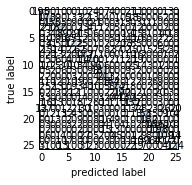

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

gnb = GaussianNB()
model = gnb.fit(train, train_labels)
pred = gnb.predict(test)
accuracy['gaussian naive bayes'] = gnb.score(test, test_labels)

t = precision_recall_fscore_support(test_labels, pred, average='weighted')
print 'F1-Weighted Average for Gaussian Naive Bayes:\t%.2f%%' % (100*t[2])
f1_w['gaussian naive bayes'] = t[2]

t = precision_recall_fscore_support(test_labels, pred, average='macro')
print 'F1-Macro Average for Gaussian Naive Bayes:\t%.2f%%\n' % (100*t[2])
f1_m['gaussian naive bayes'] = t[2]

print classification_report(test_labels, pred, target_names=label_names)
confusion['gaussian naive bayes'] = confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion['gaussian naive bayes'])
plt.show()

## Εκπαίδευση και εκτίμηση του kNN - Nearest Neighbors Classifier

O kNN διαλέγει την κλάση του δείγματος υπό εξέταση με βάση κάποιον αριθμό γειτόνων του. Στην απλή έκδοσή του, οι γείτονες είναι 5 και το βάρος τους είναι ομοιόμορφο. Ακόμη και έτσι όμως παρατηρούμε ότι πετυχαίνει ικανοποιητική ακρίβεια. Το αρνητικό αυτού του ταξινομητή είναι οι απαιτήσεις σε μνήμη και χρόνο για την ταξινόμηση κάθε νέου δείγματος.

F1-Weighted Average for kNN:	94.34%
F1-Macro Average for kNN:	94.37%

             precision    recall  f1-score   support

          A       0.99      0.99      0.99       232
          C       0.87      0.93      0.90       256
          B       0.96      0.95      0.95       206
          E       0.88      0.96      0.92       254
          D       0.90      0.90      0.90       241
          G       0.93      0.94      0.93       236
          F       0.94      0.94      0.94       219
          I       0.83      0.85      0.84       221
          H       0.95      0.96      0.96       223
          K       0.97      0.93      0.95       227
          J       0.91      0.85      0.88       222
          M       0.99      0.98      0.99       230
          L       0.98      0.97      0.98       238
          O       0.96      0.95      0.95       222
          N       0.95      0.92      0.93       251
          Q       0.96      0.90      0.93       263
          P       0.94      

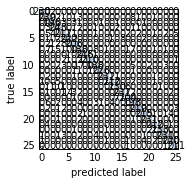

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(train, train_labels)
pred = knn.predict(test)
accuracy['knn'] = knn.score(test, test_labels)

t = precision_recall_fscore_support(test_labels, pred, average='weighted')
print 'F1-Weighted Average for kNN:\t%.2f%%' % (100*t[2])
f1_w['knn'] = t[2]

t = precision_recall_fscore_support(test_labels, pred, average='macro')
print 'F1-Macro Average for kNN:\t%.2f%%\n' % (100*t[2])
f1_m['knn'] = t[2]

print classification_report(test_labels, pred, target_names=label_names)
confusion['knn'] = confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion['knn'])
plt.show()

## Εκπαίδευση και εκτίμηση του Multi-Layer Perceptron (MLP)

Σε αυτό το στάδιο δημιουργούμε ένα perceptron, για το οποίο δεν αρχικοποιούμε καμία παράμετρο, εκτός της max_iter, για να αποφύγουμε το warning που αφορά την έλλειψη σύγκλισης με το default maximum iteration parameter. Ο solver που χρησιμοποιήθηκε ήταν ο lbfgs καθώς οι άλλοι δύο δεν ενδείκνυνται για μικρά datasets.

F1-Weighted Average for Standard MLP:	91.49%
F1-Macro Average for Standard MLP:	91.48%

             precision    recall  f1-score   support

          A       0.97      0.95      0.96       232
          C       0.93      0.90      0.91       256
          B       0.95      0.90      0.93       206
          E       0.89      0.90      0.89       254
          D       0.87      0.86      0.87       241
          G       0.86      0.93      0.89       236
          F       0.87      0.86      0.86       219
          I       0.88      0.76      0.82       221
          H       0.96      0.93      0.95       223
          K       0.97      0.93      0.95       227
          J       0.86      0.86      0.86       222
          M       0.96      0.95      0.96       230
          L       0.97      0.96      0.96       238
          O       0.89      0.94      0.91       222
          N       0.92      0.89      0.91       251
          Q       0.93      0.90      0.92       263
          

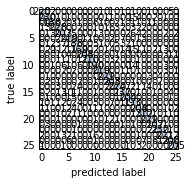

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier()
mlp.fit(train, train_labels)
pred = mlp.predict(test)

accuracy['mlp'] = mlp.score(test, test_labels)
t = precision_recall_fscore_support(test_labels, pred, average='weighted')
print 'F1-Weighted Average for Standard MLP:\t%.2f%%' % (100*t[2])
f1_w['mlp'] = t[2]

t = precision_recall_fscore_support(test_labels, pred, average='macro')
print 'F1-Macro Average for Standard MLP:\t%.2f%%\n' % (100*t[2])
print classification_report(test_labels, pred, target_names=label_names)
f1_m['mlp'] = t[2]

confusion['mlp'] = confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion['mlp'])
plt.show()

Τέλος παρουσιάζουμε τα αποτελέσματα των baseline classifiers.

Classification Accuracy (30% test set)
--------------------------------------
Gaussian Naive Bayes:		64.38%
kNN:				94.33%
MLP:				91.48%

Bar plot for F1 Macro


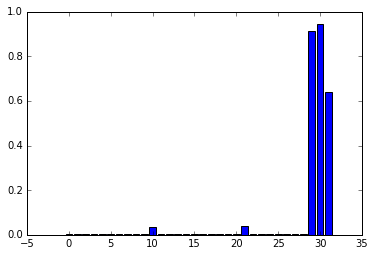

Bar plot for F1 Weighted


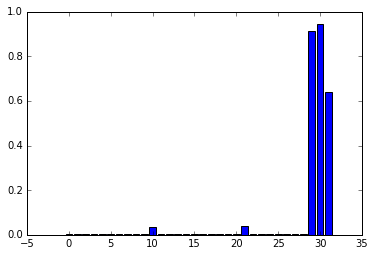

In [12]:
print "Classification Accuracy (30% test set)"
print "--------------------------------------"
print "Gaussian Naive Bayes:\t\t%.2f%%" % (100*accuracy['gaussian naive bayes'])
print "kNN:\t\t\t\t%.2f%%" % (100*accuracy['knn'])
print "MLP:\t\t\t\t%.2f%%\n" % (100*accuracy['mlp'])

import matplotlib.pyplot as plt

classifier = dc.keys()
classifier.append('mlp')
classifier.append('knn')
classifier.append('gaussian naive bayes')

print 'Bar plot for F1 Macro'
plt.bar(range(len(f1_m.keys())), [f1_m[c] for c in classifier], align='center')
plt.show()

print 'Bar plot for F1 Weighted'
plt.bar(range(len(f1_m.keys())), [f1_w[c] for c in classifier], align='center')
plt.show()

Όπως είναι εμφανής και λογικό οι 3 τελευταίοι ταξινομητές έχουν συντριπτικά καλύτερη απόδοση από τους dummy καθώς και πετυχένουν αρκετά καλά ποσοστά χωρίς ιδιαίτερη αρχικοποίηση.

# Βελτιστοποίηση Παραμέτρων

Σε αυτό το notebook η βελτιστοποίηση των υπερπαραμέτρων γίνεται στον kNN και στο MLP.

Πρώτα δημιουργούμε τα απαιτούμενα στοιχεία που θέλουμε να βάλουμε στο pipe.

Στο pipe δεν βάζουμε PCA και Oversampler ή Downsampler, καθώς είδαμε και πριν ότι οι αναλογίες στις ομάδες είναι καλές και η διαστατικότητα του προβλήματος είναι μόλις 16.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

selector = VarianceThreshold()
scaler = StandardScaler()

## Βελτιστοποίηση του kNN

Αρχικά φτιάχνουμε το pipe με τους preprocessors που δημιουργήσαμε πριν και με last step τον kNN classifier.

In [14]:
import time
from sklearn.neighbors import DistanceMetric
from imblearn.pipeline import Pipeline

opt_values = dict()

# met = ['euclidean', 'minkowski', 'manhattan']
# wei = ['uniform', 'distance']
# vthreshold = [0, 0.1]

# Μετά από μερικές δοκιμές παρατηρώ ότι η Manhattan τείνει να δίνει τις καλύτερες μετρήσεις
met = ['manhattan'] 
# σε συνδυασμό με την distance μετρική
wei = ['distance']
# και ότι τα δεδομένα αρκούν σε ένα threshold 0
vthreshold = [0]
# και ότι αυτό είναι το διάστημα των γειτόνων
k = range(1, 7)

clf = knn
pipe = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('kNN', clf)], memory = 'tmp')

Και βελτιστοποιούμε με βάση το f1_macro score.

In [15]:
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, kNN__n_neighbors=k, kNN__metric=met, kNN__weights=wei), scoring='f1_macro',  cv=5, n_jobs=-1)

start_time = time.time()
estimator.fit(train, train_labels)
mid_time = time.time()
pred = estimator.predict(test)
fin_time = time.time()

print "Fit: %.2f seconds" % (mid_time - start_time)
print "Predict: %.2f seconds" % (fin_time - mid_time)
print "Total: %.2f seconds" % (fin_time - start_time)

opt_values['f1 macro knn'] = estimator.best_params_
accuracy['f1 macro knn'] = accuracy_score(test_labels, pred)

/gpfs/fs01/user/sa2e-9b0c3afc7160f2-4596f700dc87/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/gpfs/fs01/user/sa2e-9b0c3afc7160f2-4596f700dc87/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/gpfs/fs01/user/sa2e-9b0c3afc7160f2-4596f700dc87/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/gpfs/fs01/user/sa2e-9b0c3afc7160f2-4596f700dc87/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg,

Fit: 18.73 seconds
Predict: 1.55 seconds
Total: 20.28 seconds


{'selector__threshold': 0, 'kNN__metric': 'manhattan', 'kNN__weights': 'distance', 'kNN__n_neighbors': 4}
0.952
F1-Weighted Average for Optimised kNN Weighted: 0.95
F1-Macro Average for Optimised kNN Macro: 0.95


             precision    recall  f1-score   support

          A       1.00      0.98      0.99       232
          C       0.90      0.95      0.92       256
          B       0.98      0.95      0.97       206
          E       0.93      0.97      0.95       254
          D       0.92      0.90      0.91       241
          G       0.96      0.95      0.96       236
          F       0.94      0.94      0.94       219
          I       0.85      0.85      0.85       221
          H       0.97      0.96      0.96       223
          K       0.95      0.96      0.96       227
          J       0.91      0.89      0.90       222
          M       1.00      0.97      0.98       230
          L       0.97      0.98      0.98       238
          O       0.96      0.95      0.96 

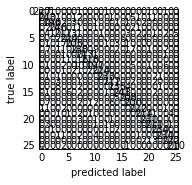

In [16]:
print opt_values['f1 macro knn']
print accuracy['f1 macro knn']

t = precision_recall_fscore_support(test_labels, pred, average='weighted')
print 'F1-Weighted Average for Optimised kNN Weighted: %.2f' % t[2]
f1_w['optimised knn macro'] = t[2]
print 'F1-Macro Average for Optimised kNN Macro: %.2f' % t[2]
t = precision_recall_fscore_support(test_labels, pred, average='macro')
f1_m['optimised knn macro'] = t[2]
print '\n'
print classification_report(test_labels, pred, target_names=label_names)
confusion['knn macro'] = confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion['knn macro'])
plt.show()

Παρατηρούμε ότι η αύξηση ήταν πολύ μικρή με την βελτιστοποίηση των παραμέτρων. Επόμενο βήμα είναι η βελτιστοποίηση με βάση το f1_weighted score.

In [17]:
import time

k = range(1, 7)
met = ['manhattan']
wei = ['distance']
vthreshold = [0]
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, kNN__n_neighbors=k, kNN__metric=met, kNN__weights=wei), scoring='f1_weighted',  cv=5, n_jobs=-1)

start_time = time.time()
estimator.fit(train, train_labels)
mid_time = time.time()
pred = estimator.predict(test)
fin_time = time.time()

print "Fit: %.2f seconds" % (mid_time - start_time)
print "Predict: %.2f seconds" % (fin_time - mid_time)
print "Total: %.2f seconds" % (fin_time - start_time)

opt_values['f1 weighted knn'] = estimator.best_params_
accuracy['f1 weighted knn'] = accuracy_score(test_labels, pred)

Fit: 19.03 seconds
Predict: 1.52 seconds
Total: 20.56 seconds


{'selector__threshold': 0, 'kNN__metric': 'manhattan', 'kNN__weights': 'distance', 'kNN__n_neighbors': 4}
0.952
F1-Weighted Average for Optimised kNN Weighted: 0.95
F1-Macro Average for Optimised kNN Macro: 0.95


             precision    recall  f1-score   support

          A       1.00      0.98      0.99       232
          C       0.90      0.95      0.92       256
          B       0.98      0.95      0.97       206
          E       0.93      0.97      0.95       254
          D       0.92      0.90      0.91       241
          G       0.96      0.95      0.96       236
          F       0.94      0.94      0.94       219
          I       0.85      0.85      0.85       221
          H       0.97      0.96      0.96       223
          K       0.95      0.96      0.96       227
          J       0.91      0.89      0.90       222
          M       1.00      0.97      0.98       230
          L       0.97      0.98      0.98       238
          O       0.96      0.95      0.96 

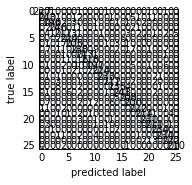

In [18]:
print opt_values['f1 weighted knn']
print accuracy['f1 weighted knn']

t = precision_recall_fscore_support(test_labels, pred, average='weighted')
print 'F1-Weighted Average for Optimised kNN Weighted: %.2f' % t[2]
f1_w['optimised knn weighted'] = t[2]
print 'F1-Macro Average for Optimised kNN Macro: %.2f' % t[2]
t = precision_recall_fscore_support(test_labels, pred, average='macro')
f1_m['optimised knn weighted'] = t[2]
print '\n'
print classification_report(test_labels, pred, target_names=label_names)

confusion['knn weighted'] = confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion['knn weighted'])
plt.show()

Παρατηρούμε ότι είτε βελτιστοποιήσουμε με βάση το macro είτε το weighted score το αποτέλεσμα είναι ίδιο, κάτι που είναι λογικό δεδομένου ότι τα δείγματα είναι ισοκατανεμημένα στο dataset.

Επίσης η βελτίωση του kNN ήταν ελάχιστη με επιδόσεις:

Accuracies before and after:
------------------------------
Before:			94.33%
After with f1_macro:	95.20%
After with f1_weighted:	95.20%

Bar plot for F1 Macro


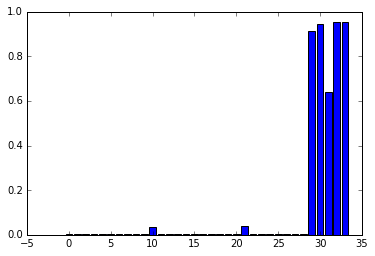

Bar plot for F1 Weighted


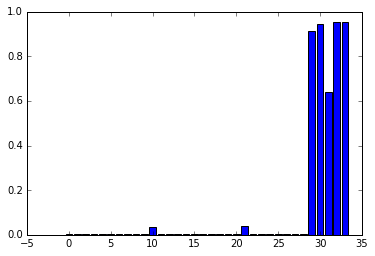

In [19]:
print 'Accuracies before and after:'
print '------------------------------'
print 'Before:\t\t\t%.2f%%' % (100*accuracy['knn'])
print 'After with f1_macro:\t%.2f%%' % (100*accuracy['f1 macro knn'])
print 'After with f1_weighted:\t%.2f%%\n' %(100*accuracy['f1 weighted knn'])

classifier = dc.keys()
classifier.append('mlp')
classifier.append('knn')
classifier.append('gaussian naive bayes')

classifier.append('optimised knn macro')
classifier.append('optimised knn weighted')
print 'Bar plot for F1 Macro'
plt.bar(range(len(f1_m.keys())), [f1_m[c] for c in classifier], align='center')
plt.show()

print 'Bar plot for F1 Weighted'
plt.bar(range(len(f1_m.keys())), [f1_w[c] for c in classifier], align='center')
plt.show()

## Βελτιστοποίηση του MLP

Αρχικά φτιάχνουμε το ίδιο pipe με πριν, αλλά με διαφορετικό classifier(last step), δηλαδή τον MLP.

Οι υπερπαράμετροι προς βελτιστοποίηση είναι οι εξής:

1. **hidden_layer_sizes**: που ελέγχει τον αριθμό των νευρώνων σε κάθε επίπεδο του MLP (στην περίπτωσή μας μόνο ένα επίπεδο).
2. **max_iter**: που ορίζει το πόσες επαναλήψεις θα κάνει ο αλγόριθμος πριν σταματήσει (δεν είναι απαραίτητο ότι δεν θα κάνει λιγότερες, απλώς είναι το άνω όριο).
3. **activation**: που ορίζει την συνάρτηση ενεργοποίησης των νευρώνων.
4. **learning_rate**: που ορίζει το ρυθμό εκμάθησης των νευρώνων.
5. **alpha**: που ορίζει το penalty του σφάλματος της L2 νόρμας.

Επίσης, υπάρχουν 3 είδη MLP στην βιβλιοθήκη. Επειδή όμως το dataset μας είναι αρκετά μεγάλο, θα χρησιμοποιηθεί ο adam ως solver που όπως αναφέρεται στην βιβλιοθήκη ενδείκνυται για μεγάλα datasets.

In [20]:
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline

mlp = MLPClassifier()

act = ['relu']
alp = [0.1]
max_it = range(510, 521, 10)
hidden_layer = range(28, 30)
learn_rate = ['constant']

vthreshold = [0, 0.1]
clf = mlp
pipe = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('MLP', clf)], memory = 'tmp')

In [21]:
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, MLP__activation=act, MLP__alpha=alp, MLP__max_iter=max_it, MLP__hidden_layer_sizes=hidden_layer, MLP__learning_rate=learn_rate), scoring='f1_macro',  cv=5, n_jobs=-1)
estimator.fit(train, train_labels)

start_time = time.time()
estimator.fit(train, train_labels)
mid_time = time.time()
pred = estimator.predict(test)
fin_time = time.time()

print "Fit: %.2f seconds" % (mid_time - start_time)
print "Predict: %.2f seconds" % (fin_time - mid_time)
print "Total: %.2f seconds" % (fin_time - start_time)

opt_values['f1 macro mlp'] = estimator.best_params_
accuracy['f1 macro mlp'] = accuracy_score(test_labels, pred)

Fit: 134.96 seconds
Predict: 0.01 seconds
Total: 134.97 seconds


{'MLP__activation': 'relu', 'MLP__alpha': 0.1, 'MLP__hidden_layer_sizes': 29, 'MLP__learning_rate': 'constant', 'selector__threshold': 0, 'MLP__max_iter': 510}
0.890833333333
F1-Weighted Average for Optimised MLP Weighted: 0.89
F1-Macro Average for Optimised MLP Macro: 0.89


             precision    recall  f1-score   support

          A       0.97      0.93      0.95       232
          C       0.89      0.86      0.87       256
          B       0.89      0.92      0.90       206
          E       0.84      0.91      0.87       254
          D       0.85      0.86      0.85       241
          G       0.85      0.82      0.84       236
          F       0.83      0.82      0.82       219
          I       0.82      0.75      0.78       221
          H       0.93      0.88      0.90       223
          K       0.94      0.89      0.91       227
          J       0.87      0.85      0.86       222
          M       0.93      0.92      0.92       230
          L       0.93      0.93 

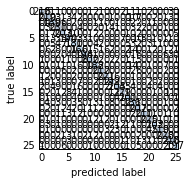

In [22]:
print opt_values['f1 macro mlp']
print accuracy['f1 macro mlp']

t = precision_recall_fscore_support(test_labels, pred, average='weighted')
print 'F1-Weighted Average for Optimised MLP Weighted: %.2f' % t[2]
f1_w['optimised mlp macro'] = t[2]
print 'F1-Macro Average for Optimised MLP Macro: %.2f' % t[2]
t = precision_recall_fscore_support(test_labels, pred, average='macro')
f1_m['optimised mlp macro'] = t[2]
print '\n'
print classification_report(test_labels, pred, target_names=label_names)

confusion['mlp macro'] = confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion['mlp macro'])
plt.show()

In [23]:
act = ['relu']
alp = [0.1]
max_it = range(510, 521, 10)
hidden_layer = range(27, 30)
learn_rate = ['constant']

vthreshold = [0, 0.1]

estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, MLP__activation=act, MLP__alpha=alp, MLP__max_iter=max_it, MLP__hidden_layer_sizes=hidden_layer, MLP__learning_rate=learn_rate), scoring='f1_macro',  cv=5, n_jobs=-1)
estimator.fit(train, train_labels)

start_time = time.time()
estimator.fit(train, train_labels)
mid_time = time.time()
pred = estimator.predict(test)
fin_time = time.time()

print "Fit: %.2f seconds" % (mid_time - start_time)
print "Predict: %.2f seconds" % (fin_time - mid_time)
print "Total: %.2f seconds" % (fin_time - start_time)

opt_values['f1 weighted mlp'] = estimator.best_params_
accuracy['f1 weighted mlp'] = accuracy_score(test_labels, pred)

Fit: 208.00 seconds
Predict: 0.01 seconds
Total: 208.01 seconds


{'MLP__activation': 'relu', 'MLP__alpha': 0.1, 'MLP__hidden_layer_sizes': 29, 'MLP__learning_rate': 'constant', 'selector__threshold': 0, 'MLP__max_iter': 510}
0.890833333333
F1-Weighted Average for Optimised MLP Weighted: 0.90
F1-Macro Average for Optimised MLP Macro: 0.90


             precision    recall  f1-score   support

          A       0.96      0.91      0.93       232
          C       0.88      0.87      0.87       256
          B       0.93      0.91      0.92       206
          E       0.84      0.90      0.87       254
          D       0.85      0.85      0.85       241
          G       0.89      0.88      0.89       236
          F       0.82      0.85      0.84       219
          I       0.86      0.77      0.81       221
          H       0.93      0.91      0.92       223
          K       0.93      0.89      0.91       227
          J       0.88      0.88      0.88       222
          M       0.91      0.93      0.92       230
          L       0.94      0.93 

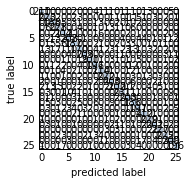

In [24]:
print opt_values['f1 macro mlp']
print accuracy['f1 macro mlp']

t = precision_recall_fscore_support(test_labels, pred, average='weighted')
print 'F1-Weighted Average for Optimised MLP Weighted: %.2f' % t[2]
f1_w['optimised mlp weighted'] = t[2]
print 'F1-Macro Average for Optimised MLP Macro: %.2f' % t[2]
t = precision_recall_fscore_support(test_labels, pred, average='macro')
f1_m['optimised mlp weighted'] = t[2]
print '\n'
print classification_report(test_labels, pred, target_names=label_names)

confusion['mlp weighted'] = confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion['mlp weighted'])
plt.show()

Accuracies before and after:
------------------------------
Before:			91.48%
After with f1_macro:	89.08%
After with f1_weighted:	89.50%

Bar plot for F1 Macro


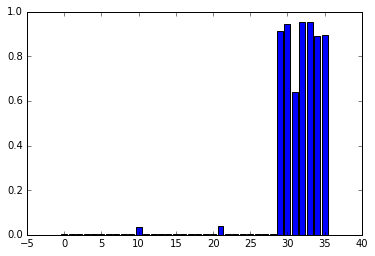

Bar plot for F1 Weighted


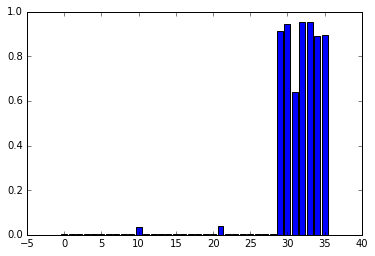

In [25]:
print 'Accuracies before and after:'
print '------------------------------'
print 'Before:\t\t\t%.2f%%' % (100*accuracy['mlp'])
print 'After with f1_macro:\t%.2f%%' % (100*accuracy['f1 macro mlp'])
print 'After with f1_weighted:\t%.2f%%\n' %(100*accuracy['f1 weighted mlp'])

classifier.append('optimised mlp macro')
classifier.append('optimised mlp weighted')

print 'Bar plot for F1 Macro'
plt.bar(range(len(f1_m.keys())), [f1_m[c] for c in classifier], align='center')
plt.show()

print 'Bar plot for F1 Weighted'
plt.bar(range(len(f1_m.keys())), [f1_w[c] for c in classifier], align='center')
plt.show()

Ομοίως και σε αυτόν τον ταξινομητή βλέπουμε ότι ενώ υπήρχε αύξηση στην αναγνώριση η επίδοσή του δεν αυξήθηκε τρομερά, δεδομένου ότι ήδη ήταν υψηλή.

Από την άλλη και στους δύο παρατηρούμε ότι η εκπαίδευσή τους με gridsearchcv και pipeline είναι αρκετά χρονοβόρα καθώς ενώ εμείς αποφύγαμε κάποιες παραμέτρους ή δεν επεκτείναμε τον χώρο αναζήτησης πολύ, θα μπορούσε να αυξάνεται εκθετικά με σωστή παραμετροποίηση.

Γενικώς παρατηρούμε από τα precisions των ταξινομητών ότι υπάρχουν γράμματα που είναι πιο εύκολα να αναγνωριστούν όπως το Α και άλλα πιο δύσκολα όπως το I ή το S, καθώς και από το recall ότι είναι εύκολο να γίνει ταξινόμησή τους ως άλλο γράμμα συχνά, πάλι για παράδειγμα το Ι.

Τέλος το f1 score μας δίνει μια καλή εκτίμηση του πόσο καλό είναι το balance μεταξύ του precision και του recall. Το f1 weighted υπολογίζει την κατανομή των στοιχείων στο dataset, ενώ το f1 macro δεν δίνει βάρη στο average score, άρα θεωρεί ισοπίθανες όλες τις κλάσεις. Και στα δύο pybooks η διαφορά τους ήταν μικρή λόγω της ισοκατανεμημένης ύπαρξης των κλάσεων στο dataset.

Από όλους τους ταξινομητές παρατηρούμε ότι ο kNN έχει την καλύτερη απόδοση παρά την απλοϊκή του κατασκευή.

**Disclaimer**: Οι παράμετροι που θεωρήθηκαν βέλτιστοι δεν είναι απαραίτητα οι καλύτερες παράμετροι, αλλά χάριν περατότητας των αλγορίθμων μειώθηκε αρκετά το search space.